# Homework 3

### 1.

We consider the LASSO problem :

\begin{equation*}
\begin{split}
\min_w & \frac{1}{2}\vert\vert Xw - y \vert\vert^2_2 + \lambda \vert\vert w \vert\vert_1\\
\iff \min_{w, z} & \frac{1}{2} \vert\vert z \vert\vert^2_2 +  \lambda \vert\vert w \vert\vert_1\\
     \text{s.t.} & z = Xw - y
\end{split}
\end{equation*}

where we introduce the dummy variable $z$ to compute the dual of the problem in a useful form.

Indeed, using this form of the problem, the Lagrangian is, with $\nu$ denoting the Lagrange multiplier :

\begin{equation*}
\begin{split}
\mathscr{L} (w, z, \nu) &= \frac{1}{2} \vert\vert z \vert\vert^2_2 + \lambda \vert\vert w \vert\vert_1 + \nu^T\left( z - Xw + y \right)\\
&= \frac{1}{2} \vert\vert z \vert\vert^2_2 + \nu^T z + \lambda \left( \vert\vert w \vert\vert_1 - \frac{1}{\lambda} \left( X^T\nu \right)^T w \right) + \nu^T y\\
\end{split}
\end{equation*}

Minimizing $\mathscr{L}(z, w, \nu)$ over $w$ is equivalent to :

$$\max_w \lambda \left( \frac{1}{\lambda} \left( X^T\nu \right)^T w - \vert\vert w \vert\vert_1 \right)$$

where we recognize the conjugate norm $\lambda \vert\vert \frac{1}{\lambda} X^T \nu \vert\vert_1^*$, therefore :

\begin{equation*}
\begin{split}
\min_{w} \mathscr{L} (w, z, \nu) &= -\infty \text{ if } \vert\vert \frac{1}{\lambda} X^T \nu \vert\vert_{\infty} > 1\\
                             &= \frac{1}{2} \vert\vert z \vert\vert^2_2 + \nu^T z + \nu^T y \text{ otherwise}\\
                             &= z^T \left( \frac{1}{2}z + \nu \right) + \nu^T y
\end{split}
\end{equation*}

We compute the gradient of $\mathscr{L}$ with respect to $z$ to minimize it (i.e. compute the Lagrange dual function $g(\nu)$) :

\begin{equation*}
\begin{split}
\nabla \mathscr{L}(z) &= \frac{1}{2} z + \nu + \frac{1}{2}z\\
                      &= z + \nu\\
\implies \nabla \mathscr{L}(z) &= 0 \iff z = -\nu
\end{split}
\end{equation*}

Therefore, we obtain :

$$g(\nu) = -\frac{1}{2} \nu^T\nu + \nu^Ty$$

and the dual problem expressed as a quadratic program is :

\begin{equation*}
\begin{split}
\min_{v} \, -g(v) &= v^T Q v + p^T v\\
       \text{s.t. } Av &\leq b
\end{split}
\end{equation*}

where $v = \nu, Q = \frac{1}{2} I_n, p = -y,$
\begin{align}
A &= \begin{bmatrix}
X^T\\
-X^T
\end{bmatrix}
\end{align}
and $b = \lambda \mathbb{1}_{2d}$ (which is $\vert\vert \frac{1}{\lambda} X^T\nu \vert\vert_\infty \leq 1$ written in matrix form)

### 2.

Let us now implement the barrier method to solve this dual problem.



In [284]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Union
import sys

In [285]:
# Backtracking Line Search params
BLS_ALPHA = 0.1
BLS_BETA = 0.7

# Newton precision
NEWTON_EPSILON = 1e-8

LOGBARR_MU = 10.  # path update : t <- µ * t
LOGBARR_T0 = 1.  # first t value (start of path)

In [286]:
def log_barrier(vals: np.ndarray) -> float:
    """
    Log barrier function. Expects NEGATIVE values as inputs.
    (This is the function "phi" from slide 7 of Lecture 5)

    :param vals: value of constraint functions
    :return: log barrier evaluation
    """
    if np.any(vals >= 0):
        raise ValueError('[log_barrier] Positive value encountered')

    return -np.sum(np.log(-vals))

In [287]:
def check_objective_def(A: np.ndarray,
                        b: np.ndarray,
):
    """
    Create a function that checks if the objective is defined

    :param A: the inequality constraint matrix
    :param b: the inequality constraint vector
    :return: A function of x that returns True if Ax - b < 0
    """
    def _check(x):
        u = A @ x
        u = u - b
        return np.all(u < 0)

    return _check

In [288]:
def bls(f: Callable,
        gradf_x: Union[np.ndarray, float],
        x: Union[np.ndarray, float],
        delta_x: Union[np.ndarray, float],
        alpha: float,
        beta: float,
        check_def: Callable,
        ) -> float:
    """
    Backtracking Line Search algorithm.
    The algorithm may not converge if we are very close to the optimum,
    therefore we break out of the loop if the step length becomes zero
    (the loop becomes infinite in this case)

    :param f: the objective function (real-valued)
    :param gradf_x: the gradient of f at x
    :param x: the current point from which to descent
    :param delta_x: the descent direction
    :param alpha: parameter in [0, 1/2]
    :param beta: shrinkage parameter in [0, 1)
    :param check_def: function that returns True on an input v if f(v) is defined
    :return: the optimal (if reached) step length t
    """
    t = 1.

    while (
            not check_def(x + t * delta_x)
            or f(x + t * delta_x) >= f(x) + alpha * t * np.dot(gradf_x, delta_x)
    ):
        t = beta * t
        if t < sys.float_info.epsilon:
            break

    return t

#### Computation of the gradient and the Hessian


The gradient and Hessian of $g_t(v) = t\left( v^TQv + p^Tv \right) - \sum\limits_{k=1}^{2d} \log \left( b - Av \right)_k$ are :

$$\nabla g_t(v) = t(2Qv + p) - \sum_{k=1}^{2d} \frac{1}{(Av - b)_k} A^T_k$$

where $A^T_k$ is the $k$-th column of $A^T$ i.e. the $k$-th line of $A$, and

$$\nabla^2 g_t(v) = t2Q + \sum_{k=1}^{2d} \frac{1}{(Av - b)_k^2} M(k)$$

where

$$M(k)_{ij} = A_{ki} A_{kj}$$

i.e. $M(k)$ is the "tensor product" of the $k$-th line of $A$ with itself :

\begin{align}
M(k) &= \begin{bmatrix}
A_{k1}\\
\vdots\\
A_{kn}\\
\end{bmatrix}
\begin{bmatrix}
A_{k1} \hdots A_{kn}
\end{bmatrix}
\end{align}

Using the element-wise multiplication rule of NumPy arrays, these weighted sums are written in short expressions in the code below.

In [289]:
def centering_step(
        Q: np.ndarray,
        p: np.ndarray,
        A: np.ndarray,
        b: np.ndarray,
        t: float,
        v0: np.ndarray,
        eps: float
) -> np.ndarray:
    """
    Perform the centering step of the log-barrier algorithm.
    Compute the steepest descent in local Hessian norm (Newton algorithm)
    and choose a step length using backtracking line search

    :param Q: Hessian of the original objective
    :param p: linear coefficients of the original objective
    :param A:
    :param b:
    :param t:
    :param v0:
    :param eps:
    :return:
    """

    objective_f = lambda v: t * (v.T @ Q @ v + p @ v) + log_barrier(A @ v - b)
    def_checker = check_objective_def(A, b)
    v = v0
    v_history = [v]
    previous_decrement = None  # debug purposes (check decreasing decrement)

    while True:
        # Compute gradient and Hessian of the objective
        u = A @ v - b
        grad = t * (2 * Q @ v + p) - np.sum(1 / u * A.T, axis=1)  # sum( 1/(Av-b)[k]*(k-th line of A) )

        barrier_hess = (1 / u**2 * A.T) @ A
        hess = t * 2 * Q + barrier_hess

        delta_v = np.linalg.solve(hess, -grad)  # Newton descent direction
        newton_decrement_sq = np.dot(grad, -delta_v)

        # Sanity check
        if previous_decrement is None:
            previous_decrement = newton_decrement_sq
        if newton_decrement_sq - previous_decrement > 0.:
            print('[WARNING][centering_step] Newton decrement increasing')

        # Stop
        if 0.5 * newton_decrement_sq <= eps:
            return np.array(v_history, dtype=float)

        # Descend
        step_l = bls(
            f=objective_f,
            gradf_x=grad,
            x=v,
            delta_x=delta_v,
            alpha=BLS_ALPHA,
            beta=BLS_BETA,
            check_def=def_checker,
        )
        reached_zero = step_l < sys.float_info.epsilon
        if reached_zero:
            return np.array(v_history, dtype=float)

        v = v + step_l * delta_v
        v_history.append(v)


In [290]:
def barr_method(
        Q: np.ndarray,
        p: np.ndarray,
        A: np.ndarray,
        b: np.ndarray,
        v0: np.ndarray,
        eps: float,
        mu=LOGBARR_MU,
        t0=LOGBARR_T0
) -> np.ndarray:
    def_checker = check_objective_def(A, b)
    if not def_checker(v0):
        raise ValueError('The log barrier is not defined for the input v0')

    m = len(b)
    t = t0
    v_history = [v0]
    v = v0

    while True:
        v = centering_step(Q=Q,
                           p=p,
                           A=A,
                           b=b,
                           t=t,
                           v0=v,
                           eps=NEWTON_EPSILON)[-1]

        v_history.append(v)

        if m / t < eps:
            break

        t = mu * t

    return np.array(v_history, dtype=float)

### 3.

We now test the implemented LASSO solver using random data

In [291]:
# A very small example
n = 3
d = 2
scale = 100.
X = scale * 2 * (np.random.rand(n, d) - 0.5)  # n x's in R^d, in rows
y = 2 * (np.random.rand(n) - 0.5)  # n observations
_lambda = 10.

Q = 0.5 * np.eye(n)
p = -y
A = np.vstack([X.T, -X.T])
b = np.full(shape=2 * d, fill_value=_lambda)

In [292]:
v0 = np.zeros(shape=n)  # v0 stricly feasible (for all lambda > 0)
v_hist = barr_method(Q=Q,
                     p=p,
                     A=A,
                     b=b,
                     v0=v0,
                     eps=1e-6)

In [293]:
def dual_objective(v):
    res = np.zeros(len(v), dtype=float)
    for i, _v in enumerate(v):
        res[i] = np.dot(_v, np.dot(Q, _v)) + np.dot(p, _v)
    return res

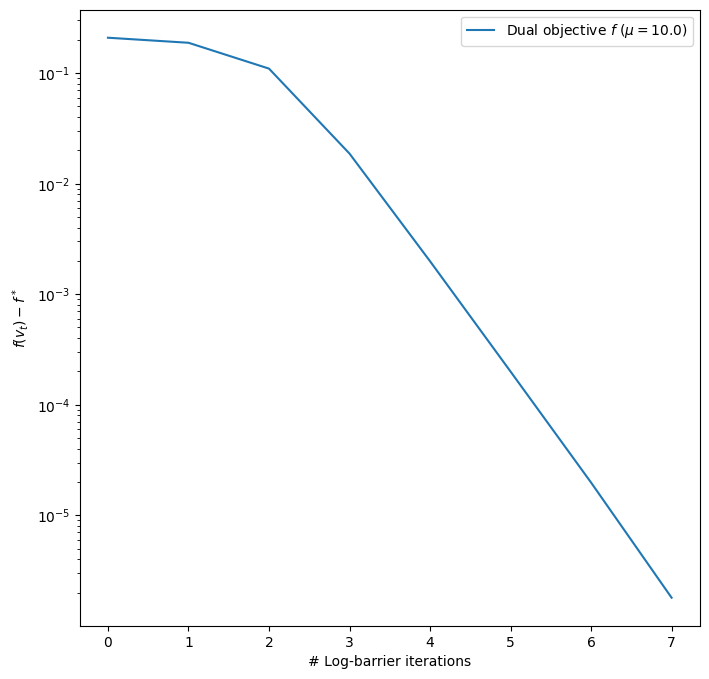

In [294]:
plt.figure(figsize=(8, 8))
plt.semilogy(dual_objective(v_hist[:-1]) - dual_objective([v_hist[-1]]), label=f'Dual objective $f$ ($\mu = {LOGBARR_MU})$')
plt.legend()
plt.ylabel('$f(v_t) - f^*$')
_ = plt.xlabel('# Log-barrier iterations')

As expected, a linear convergence in semilog scale

In [295]:
# A more complex example
n = 25
d = 500

scale = 100.
X = scale * 2 * (np.random.rand(n, d) - 0.5)  # n x's in R^d, in rows
y = 2 * (np.random.rand(n) - 0.5)  # n observations
_lambda = 10

Q = 0.5 * np.eye(n)
p = -y
A = np.vstack([X.T, -X.T])
b = np.full(shape=2 * d, fill_value=_lambda)

In [296]:
print(f'X^T X is singular : {np.linalg.cond(X.T @ X) >= 1 / sys.float_info.epsilon}')

X^T X is singular : True


In [297]:
v0 = np.zeros(shape=n)  # v0 stricly feasible (for all lambda > 0)
v_hist = barr_method(Q=Q,
                     p=p,
                     A=A,
                     b=b,
                     v0=v0,
                     eps=1e-12)

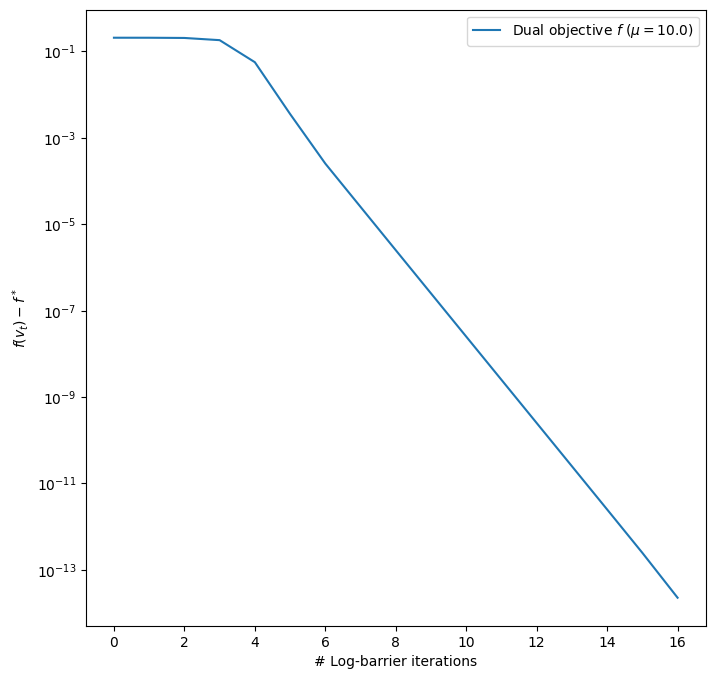

In [298]:
plt.figure(figsize=(8, 8))
plt.semilogy(dual_objective(v_hist[:-1]) - dual_objective([v_hist[-1]]), label=f'Dual objective $f$ ($\mu = {LOGBARR_MU})$')
plt.legend()
plt.ylabel('$f(v_t) - f^*$')
_ = plt.xlabel('# Log-barrier iterations')

Still a very quick convergence, both in number of iterations and in time !

We must now relate the optimum of the dual with the optimum of the primal. The primal

\begin{equation*}
\begin{split}
\min_{w, z} & \frac{1}{2} \vert\vert z \vert\vert^2_2 +  \lambda \vert\vert w \vert\vert_1\\
     \text{s.t. } & z = Xw - y
\end{split}
\end{equation*}
is convex (by convexity of norms in the objective function, and convexity of the linear inequality constraints), but it is not clear is Slater's condition is verified as the feasible set of $(w, z)$ values is intricate. However, using the steps we made when computing the dual, we can relate the optimal residues with the optimal parameter of the dual :

\begin{equation*}
\begin{split}
z^* &= -\nu^* \text{ by definition of the Lagrange dual function (from } \nabla \mathscr{L}(z, \nu ) = 0 \iff z = -\nu \text{ )}\\
X w^* &= z^* + y \text{ by constraints}\\
\iff w^* &= \left( X^T X \right)^{-1} X^T (z^* + y) \text{ if rank}(X) = d
\end{split}
\end{equation*}

In practice, if $n < d$, we always have $\text{rank}(X) < d$. However, solving the system to get a value of $w^*$ still results in a solution of the primal, with the same $l_1$ norm and the same fitted values (and therefore, the same residues) as shown by [Tibshirani (2012), The Lasso Problem and Uniqueness](https://arxiv.org/abs/1206.0313). It may be difficult to choose the "right" $w^*$ value as it is difficult to define such a notion, particularly when different candidates have different non-zero coefficients (supports). In the same paper, Tibshirani derives a sufficient condition for uniqueness : considering the set

$$\varepsilon = \{ i \in \{1, ..., d\}, \vert X_i^T (X w^* - y) \vert = \lambda \}$$

where $X_i \in \mathbb{R}^n$ denotes a column of $X$, and the matrix $X_\varepsilon$ defined by the concatenation of the columns $X_j, j \in \varepsilon$, then the solution is unique if $\text{rank}(X_\varepsilon) = \text{Card} (\varepsilon)$, and, denoting $s$ the vector containing the signs of the elements of $X_\varepsilon^T (y - Xw^*)$ :

\begin{equation*}
\begin{split}
w^*_\varepsilon &= \left( X_\varepsilon^T X_\varepsilon \right)^{-1} \left( X^T_\varepsilon y - \lambda s \right)\\
w^*_{\bar{\varepsilon}} &= 0\\
\end{split}
\end{equation*}

where $w^*_\varepsilon$ denotes the vector of components of $w^*$ whose indices are in $\varepsilon$

We can try to apply this criterion to get the solution.

In [299]:
def compute_epsilon_set(X,
                        resid,
                        _lambda,
                        tol=1e-8
                        ):
    X_cols = X.T
    epsilon_set = []
    for i, col in enumerate(X_cols):
        if abs(abs((np.dot(col, resid))) - _lambda) < tol:
            epsilon_set.append(i)

    return epsilon_set

In [300]:
eps_set = compute_epsilon_set(X, -v_hist[-1], _lambda=_lambda)
print(f'Size of epsilon set : {len(eps_set)}')

Size of epsilon set : 25


In [301]:
def compute_w_epsilon(X,
                      resid,
                      y,
                      _lambda,
                      ):
    eps_set = compute_epsilon_set(X, resid, _lambda)
    X_epsilon = X.T[eps_set].T
    s = np.sign(np.dot(X_epsilon.T, -resid)) # -resid is y - Xw
    w_epsilon_nonzero = np.dot(np.linalg.inv(X_epsilon.T @ X_epsilon), np.dot(X_epsilon, y) - _lambda * s)
    w_epsilon = np.zeros(shape=len(X[0]), dtype=float)
    if eps_set:
        for i, loc in enumerate(eps_set):
            w_epsilon[loc] = w_epsilon_nonzero[i]
    else:
        print('WARNING : epsilon set is empty !')
    return w_epsilon

In [302]:
w_eps = compute_w_epsilon(X, resid=-v_hist[-1], y=y, _lambda=_lambda)

When $\lambda$ is big (for example, in the case $\lambda = 10$ for these randomly-generated samples), the epsilon set is empty, since the residues aren't large enough with respect to $\lambda$. For lower values of $\lambda$, we get $\varepsilon \neq \emptyset$. Note that $\varepsilon = \emptyset$ does not imply that the solution is not unique, as $\varepsilon \neq \emptyset$ is only a sufficient condition for uniqueness.

In [303]:
z_star = -v_hist[-1]
w_star = np.linalg.solve(X.T @ X, np.dot(X.T, z_star + y))  # If eps_set is empty

In [304]:
print(f'Minimal component of w_star : {np.min(np.abs(w_star))}\n'
      f'l1-norm : {np.linalg.norm(w_star, ord=1)}')  # w_star practically null for large lambda !

# Check if the dual constraint is saturated
nu_star = -z_star
u = A @ nu_star - b
print(f'Number of saturated constraints : {np.count_nonzero(np.abs(u) < 1e-10)}')

# Compare w_star and w_eps
print(f'l1-norm of w_eps : {np.linalg.norm(w_eps, ord=1)}\n'
      f'Squared norm of residues associated to w_star : {np.linalg.norm(np.dot(X, w_star) - y)**2}\n'
      f'Squared norm of residues associated to w_eps : {np.linalg.norm(np.dot(X, w_eps) - y)**2}')

Minimal component of w_star : 3.731637833095194e-06
l1-norm : 1.406615463829619
Number of saturated constraints : 25
l1-norm of w_eps : 0.638973353439962
Squared norm of residues associated to w_star : 0.006946140234396639
Squared norm of residues associated to w_eps : 59.16720418916959


Let us now study the impact of $\mu$ on $w^*$.

In [305]:
mus = np.array([2., 10., 30., 70., 100., 130.,])
histories = []
z_stars = []
w_stars = []

for mu in mus:
    histories.append(barr_method(
        Q,
        p,
        A,
        b,
        v0,
        eps=1e-6,
        mu=mu,
        t0=LOGBARR_T0,
    ))

    z_stars.append(-histories[-1][-1])

    # If epsilon set is empty, solve this way
    w_stars.append(
        np.linalg.solve(X.T @ X, np.dot(X.T, z_star + y))
    )

z_stars = np.array(z_stars)
w_stars = np.array(w_stars)

In [306]:
# Strong duality check
primal_optima = np.array([0.5 * np.linalg.norm(z)**2 + _lambda * np.linalg.norm(w, ord=1) for (z, w) in zip(z_stars, w_stars)])
dual_optima = np.array([-( -z.T @ Q @ -z + p.T @ -z ) for z in z_stars])
print(f'Duality gaps : '
      f'{primal_optima - dual_optima}')

# Check residue coherence
print(f'Residues are all close : '
      f'{np.allclose(z_stars, [z_stars[0] for _ in range(len(z_stars))], atol=1e-16)}')

# Check if w_stars are all close
print(f'w_stars are all close : '
      f'{np.allclose(w_stars, [w_stars[0] for _ in range(len(w_stars))], atol=1e-16)}')

Duality gaps : [13.86300134 13.86300132 13.86300132 13.86300134 13.86300132 13.86300132]
Residues are all close : False
w_stars are all close : True


Note that we lose strong duality as $\lambda$ decreases (or as the scale of the data matrix $X$ increases, with respect to $\lambda$)

$w^*$ is not impacted at all by the choice of $\mu$, therefore, we can simply choose any value of $\mu$ for which the convergence is empirically fast.
Moreover, the above check seems to show that the solution to the problem is in fact unique, as predicted by Lemma 4 in Tibshirani 2012, which states that if the points are drawn from a continuous distribution on $\mathbb{R}^{np}$, the solution is almost surely unique. Since we draw points uniformly, we indeed get a unique optimum.

However, we see the residues are different (for lower values of $\lambda$) in the above code, in fact they are quite close but not using such an extreme tolerance threshold :

In [307]:
# Keep in mind : the observations range from -1 to 1
print(f'Residues are all close : '
      f'{np.allclose(z_stars, [z_stars[0] for _ in range(len(z_stars))], atol=1e-6)}')

Residues are all close : True
